In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import GillespieSim as gs

In [3]:

def permease_solution(mrna, permease, tau):
    gamma = 0.0231
    alpha = 1000
    k_p = 0.00231
    yss = ((alpha * k_p * mrna)/gamma)
    return  yss + (permease - yss) * np.exp(-gamma*tau)


def beta(tmg):
    return 0.00123 * pow(tmg, 0.6)


def intrtmg(beta, permease):
    return  beta * permease


def tetramers(monomers):
    if monomers > 0:
        result = monomers/100
    else:
        result = 0
    return result
   

def activelacI(intrtmg, tetramers):
    if intrtmg > 0:
        initialtmg = 0.12
        n = 2   
        tetramers = round(tetramers, 4)
        intrtmg = round(intrtmg, 4)
        result = round(1/((1 + (intrtmg/initialtmg)**n) * tetramers), 4)
    else:
        result = 0
    return result

    

def monomers(monomers, tau):
    if monomers >= 0:
        k_R = 15.4
        gamma = 0.0231
        result = (k_R - gamma * monomers)*tau
    else:
        result =  0
    return result


def promoter_on(tetramers):
    if tetramers > 0:
        R_0 = 0.04
        lamda_lacI = 15
        result = lamda_lacI*(R_0/tetramers)
    else:
        result = 0
    return result
    

def promoter_off(activelacI,tetramers):    
    if tetramers > 0:
        lamda_lacI = 15
        result = lamda_lacI*(activelacI/tetramers)
    else:
        result = 0
    return result


In [4]:


lacI_model = gs.ReactionModel(

        species = {
                'Promoter': 1,
                'mRNA': 0,
                'Beta': 0,              
                'Intracellular_tmg': 0,
                'LacI_Tetramers': 0,   
                'Active_LacI': 0,      
                'Permease': 0,        
                'LacI_monomer': 0,
                'TMG': 40,
                'Promoter_on': 0,
                'Promoter_off':0},  
        
        propensities = {
                        'kc_mRNA': 2,
                        'kd_mRNA': np.log(2)/2.5},

        reactions = {
                        'Transcription':        ['kc_mRNA', 'Promoter'],
                        'mRNA_Degradation':     ['kd_mRNA', 'mRNA'],
                        'Promoter_activation':  ['Promoter_on'],
                        'Promoter_inactivation':['Promoter_off']},
        
        q = {
                'Transcription':         {'create':       ['mRNA']},
                'mRNA_Degradation':      {'destroy':      ['mRNA']},
                'Promoter_activation':   {'activate':     ['Promoter']},
                'Promoter_inactivation': {'deactivate':   ['Promoter']}},
                
        math_model= {
                        'Beta':                beta,
                        'Intracellular_tmg':   intrtmg,
                        'LacI_Tetramers':      tetramers,
                        'Active_LacI':         activelacI,
                        'Permease':            permease_solution,
                        'LacI_monomer':        monomers,
                        'Promoter_on':         promoter_on,
                        'Promoter_off':        promoter_off},

        interaction_map = {       
                        'Beta':                 ['TMG'],
                        'Intracellular_tmg':    ['Beta', 'Permease'],
                        'LacI_Tetramers':       ['LacI_monomer'],
                        'Active_LacI':          ['Intracellular_tmg', 'LacI_Tetramers'],
                        'Permease':             ['mRNA', 'Permease', 'Tau'],
                        'LacI_monomer':         ['LacI_monomer', 'Tau'],
                        'Promoter_on':          ['LacI_Tetramers'],
                        'Promoter_off':         ['Active_LacI', 'LacI_Tetramers']})

In [5]:
lacI_model.show_eqs()
lacI_model.show_species()

{'Promoter': 1,
 'mRNA': 0,
 'Beta': 0,
 'Intracellular_tmg': 0,
 'LacI_Tetramers': 0,
 'Active_LacI': 0,
 'Permease': 0,
 'LacI_monomer': 0,
 'TMG': 40,
 'Promoter_on': 0,
 'Promoter_off': 0}

In [6]:
LacI_sim = gs.Gillespie(tmax=720, sampling_time = 0.1,reaction_model = lacI_model, model_name='lacI_model', cells=1)
LacI_sim.simulate()

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


In [7]:
lacI_model.show_eqs()
lacI_model.show_species()

{'Promoter': 0,
 'mRNA': 0,
 'Beta': 0.0112,
 'Intracellular_tmg': 0.0,
 'LacI_Tetramers': inf,
 'Active_LacI': 0,
 'Permease': 0.0,
 'LacI_monomer': -inf,
 'TMG': 40,
 'Promoter_on': 0,
 'Promoter_off': 0}

In [8]:
df = pd.read_csv('lacI_model.csv', delimiter='|')
df.head()

,Promoter,mRNA,Beta,Intracellular_tmg,LacI_Tetramers,Active_LacI,Permease,LacI_monomer,TMG,Promoter_on,Promoter_off,time,cell
0,1,0,0.0112,0.0000,0.0000,0.0000,0.0000,5.1313,40,0.0000,0.0000,0.0,1
1,1,1,0.0112,0.0000,0.0043,0.0000,1.9221,12.9307,40,11.6959,0.0000,0.1,1
2,1,2,0.0112,0.0230,0.0014,158.3189,4.5666,8.5114,40,98.3607,18426.3934,0.2,1
3,0,2,0.0112,0.0511,0.0000,inf,9.4365,16.8230,40,0.0000,0.0000,0.3,1
4,0,2,0.0112,0.1057,0.1682,inf,13.0441,12.4204,40,0.0000,0.0000,0.4,1


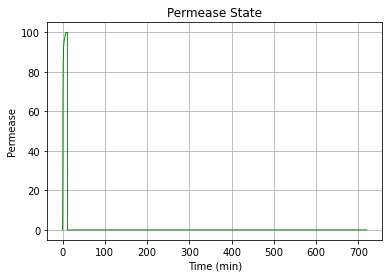

In [9]:
plt.title('Permease State')
plt.ylabel('Permease')
plt.xlabel('Time (min)')
plt.plot(df.time, df.Permease, 'g', lw=0.9)
plt.grid(True)

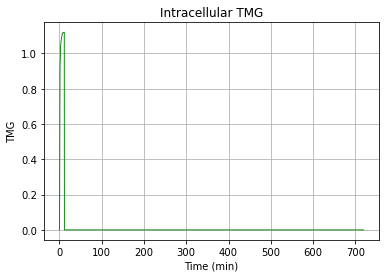

In [10]:
plt.title('Intracellular TMG')
plt.ylabel('TMG')
plt.xlabel('Time (min)')
plt.plot(df.time, df.Intracellular_tmg, 'g', lw=0.9)
plt.grid(True)

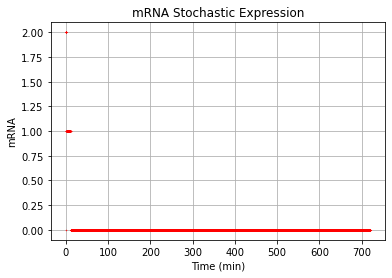

In [11]:
plt.title('mRNA Stochastic Expression')
plt.ylabel('mRNA')
plt.xlabel('Time (min)')
plt.plot(df.time, df.mRNA, 'ro', ms=0.5)
plt.grid(True)

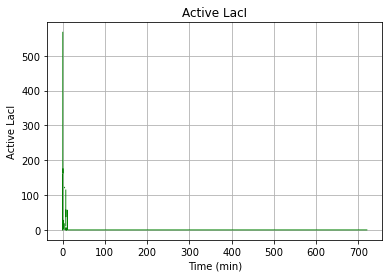

In [12]:
plt.title('Active LacI')
plt.ylabel('Active LacI')
plt.xlabel('Time (min)')
plt.plot(df.time, df.Active_LacI, 'g', lw=0.9)
plt.grid(True)

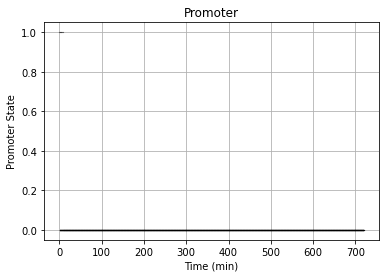

In [13]:
plt.xlabel('Time (min)')
plt.ylabel('Promoter State')
plt.title('Promoter')
plt.plot(df.time, df.Promoter, 'ko', ms=0.1)
plt.grid(True)

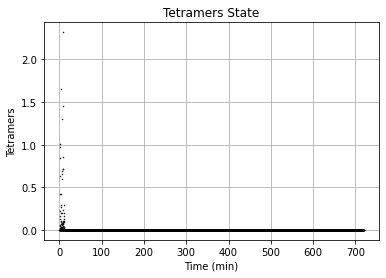

In [14]:
plt.xlabel('Time (min)')
plt.ylabel('Tetramers')
plt.title('Tetramers State')
plt.plot(df.time, df.LacI_Tetramers, 'ko',ms= 0.5, lw=0.5)
plt.grid(True)

In [15]:
lacI_model.show_species()

{'Promoter': 0,
 'mRNA': 0,
 'Beta': 0.0112,
 'Intracellular_tmg': 0.0,
 'LacI_Tetramers': inf,
 'Active_LacI': 0,
 'Permease': 0.0,
 'LacI_monomer': -inf,
 'TMG': 40,
 'Promoter_on': 0,
 'Promoter_off': 0}